### Libs

In [46]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

In [58]:
N, L, Hin, Hout = 10, 100, 2, 3

m = nn.RNN(Hin,Hout, batch_first=True)
x = torch.ones(N, L, Hin)

out, h_out = m(x)

h_out.shape

for i in m.named_parameters():
    print(i[0])
    print(i[1].shape)

weight_ih_l0
torch.Size([3, 2])
weight_hh_l0
torch.Size([3, 3])
bias_ih_l0
torch.Size([3])
bias_hh_l0
torch.Size([3])


### Helper Functions

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

### Nets

In [5]:
os.environ['TORCH_HOME'] = './pretrain_models'
VGG = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)

Using cache found in ./pretrain_models\hub\pytorch_vision_v0.10.0


In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        features = 64
        self.features = features

        self.init_size = 2
        self.linear_layer = nn.Sequential(nn.Linear(latent_dim, (8*features) * (self.init_size**2)))

        # VGG
        #(64, 32, 32)
        #(128, 16, 16)
        #(256, 8, 8)
        #(256, 8, 8)

        self.conv_layers = nn.Sequential(
            OrderedDict(
                [
                    # (512, 2, 2)

                    ("first_layer", Generator._block(8*features, 4*features, False, 2)),
                    # (256, 4, 4)

                    ("middle4", Generator._block(4*features, 4*features, True, 2)), # TransferLearning
                    # (256, 8, 8)

                    ("middle3", Generator._block(4*features, 4*features, True, 1)), # TransferLearning
                    # (256, 8, 8)

                    ("middle2", Generator._block(4*features, 2*features, True, 2)), # TransferLearning
                    # (128, 16, 16)

                    ("middle1", Generator._block(2*features, 1*features, True, 2)), # TransferLearning
                    # (64, 32, 32)

                    ("middle0", Generator._block(1*features, 3, True, 1)),
                    # (3, 32, 32)

                    ("last_layer", nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1)),
                    ("tanh", nn.Tanh())
                    # (1, 32, 32)
                ]
            )
        )


    def forward(self, z):
        out = self.linear_layer(z)
        out = out.view(out.shape[0], 8*self.features, self.init_size, self.init_size)
        image = self.conv_layers(out)
        return image



    @staticmethod
    def _block(in_channels, out_channels, activation, upsample):
        if activation:
            return nn.Sequential(
                nn.BatchNorm2d(in_channels, 0.8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Upsample(scale_factor=upsample),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )
        else:
            return nn.Sequential(
                nn.BatchNorm2d(in_channels, 0.8),
                nn.Upsample(scale_factor=upsample),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            )

In [7]:
# TEST

N, z_dim = 50, 100
C, H, W = 3, 32, 32

z = torch.empty(N, z_dim)
x = torch.ones(N, C, H, W).to(torch.float)
G = Generator(100)

In [8]:
def get_vgg_loss(Generator, z, VGG, image):

    critic = nn.MSELoss()

    linear_out = Generator.linear_layer(z).view(-1, 8*Generator.features, Generator.init_size, Generator.init_size)

    # Layer 4 : (256, 8, 8)
    loss_4 = critic(Generator.conv_layers[0:1+1](linear_out), VGG.features[0:9+1](image))
    # Layer3 : (256, 8, 8)
    loss_3 = critic(Generator.conv_layers[0:2+1](linear_out), VGG.features[0:7+1](image))
    # Layer2  : (128, 16, 16)
    loss_2 = critic(Generator.conv_layers[0:3+1](linear_out), VGG.features[0:4+1](image))
    # Layer1 :  (64, 32, 32)
    loss_1 = critic(Generator.conv_layers[0:4+1](linear_out), VGG.features[0:1+1](image))


    return (1/4)*(loss_1 + loss_2 + loss_3 + loss_4)

In [9]:
# TEST

get_vgg_loss(G, z, VGG, x)

tensor(0.6140, grad_fn=<MulBackward0>)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_layers = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # self.ds_size = img_size // 2 ** 4 # for img_size = 96
        self.ds_size = 2 # for img_size = 28
        self.adverse_layer = nn.Sequential(nn.Linear(128 * self.ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, image):
        out = self.conv_layers(image)
        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

In [11]:
# TEST
G = Generator(100)
x = torch.ones(1, 1, 28, 28).to(torch.float)
z = torch.FloatTensor(np.random.normal(0, 1, (x.shape[0], 100)))
G(z).shape

torch.Size([1, 1, 32, 32])

In [12]:
# TEST
D = Discriminator(1, 28)
x = torch.ones(1, 1, 28, 28).to(torch.float)
D(x).shape

torch.Size([1, 1])

### Hyperparameters

In [13]:
device = 'cpu'

root_save = "./best_models"
root_ds = "./MNIST"

batch_size = 128
img_size = 32
latent_dim = 100
channels = 1
num_epochs = 1000
sample_interval = 1

### Dataset

In [14]:
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize(img_size),
    transforms.Normalize((0.5,) , (0.5,))
])

train_data=datasets.MNIST(root=root_ds,
                          train=True, transform=trans, download=True)
test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [15]:
def get_index(class_num, dataset, mode:str):
    if mode == 'train':
        class_indx = torch.nonzero(
                dataset.train_labels == class_num * torch.ones_like(dataset.train_labels)
        )

    if mode == 'test':
        class_indx = torch.nonzero(
                dataset.test_labels == class_num * torch.ones_like(dataset.test_labels)
        )

    class_indx = class_indx.squeeze(1)
    return class_indx

In [16]:
train_sampler = SubsetRandomSampler(get_index(8, train_data, 'train'))
test_sampler = SubsetRandomSampler(get_index(8, test_data, 'test'))

train_loader=DataLoader(train_data, batch_size= batch_size, sampler=train_sampler)
test_loader=DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Loss

In [17]:
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator(channels=channels, img_size=img_size).to(device)
VGG = VGG.to(device)

In [18]:
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

In [19]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [20]:
generator = generator.apply(weights_init_normal)
discriminator = discriminator.apply(weights_init_normal)

### Train

In [21]:
for epoch in range(1, num_epochs):
    total_G_loss = 0.0
    total_D_loss = 0.0
    for i, (real_images, _) in enumerate(train_loader):
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        real_images = real_images.to(device)

        #  Train Generator
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) +\
                 get_vgg_loss(generator, z, VGG, real_images.repeat(1,3,1,1))
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()

        #  Train Discriminator
        optimizer_D.zero_grad()
        discriminator_opinion_real = discriminator(real_images)
        discriminator_opinion_fake = discriminator(gen_imgs.detach())
        real_loss = adversarial_loss(discriminator_opinion_real, valid)
        fake_loss = adversarial_loss(discriminator_opinion_fake, fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()

    if epoch % sample_interval ==0:

        # show a sample from generator
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z)
        show_tensor_images(gen_imgs)
        show_tensor_images(real_images)



        # show losses
        print(
                "[Epoch {}/{}] \t[D loss: {:.3f}] \t[G loss: {:.3f}]".format(
                    epoch, num_epochs, total_D_loss, total_G_loss)
            )

        # save all
        torch.save({"epoch": epoch,
            "state_dict_G": generator.state_dict(),
            "state_dict_D": discriminator.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict()
           }, root_save + f"/epoch{epoch}_disloss{total_D_loss}_genloss{total_G_loss}.pt")

KeyboardInterrupt: 

In [ ]:
"""
if epoch % sample_interval == 0 and i % (len(dataloader)/5) == 0:
    save_image(gen_imgs.data[0,0],
               "images/{}_{}.png".format(str(epoch).zfill(len(str(num_epochs))),
                                         str(i).zfill(len(str(len(dataloader))))),
               normalize=True)
"""

### End

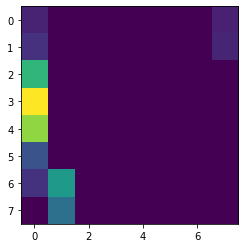

In [45]:
plt.imshow(
    VGG.features[0:9+1](real_images.repeat(1,3,1,1))[0][2].detach().cpu()
)

In [ ]:
loss_4 = critic(Generator.conv_layers[0:1+1](linear_out), VGG.features[0:9+1](image))
# Layer3 : (256, 8, 8)
loss_3 = critic(Generator.conv_layers[0:2+1](linear_out), VGG.features[0:7+1](image))
# Layer2  : (128, 16, 16)
loss_2 = critic(Generator.conv_layers[0:3+1](linear_out), VGG.features[0:4+1](image))
# Layer1 :  (64, 32, 32)
loss_1 = critic(Generator.conv_layers[0:4+1](linear_out), VGG.features[0:1+1](image))